In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics

from sklearn import neighbors
from sklearn import naive_bayes
from sklearn import discriminant_analysis
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn import svm


# Part 1: Visualizing the Data
For categorical features like "SMOKING," a "0" indicates that the person does ***not*** belong to this class, while a "1" indicates that a person does belong to this class.

In [2]:
data_file = "../data/survey-lung-cancer.csv"
GENDER = "GENDER"
AGE = "AGE"
SMOKING = "SMOKING"
LUNG_CANCER = "LUNG_CANCER"
CHRONIC_DISEASE = "CHRONIC DISEASE"
data = pd.read_csv(data_file)

# Convert the "1/2" categorical values to "0/1" and "No/Yes" in the lung cancer column into "0/1"
for col in data.columns:
    if col != AGE:
        data[col] = data[col].astype('category').cat.codes      
data 

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,1,69,0,1,1,0,0,1,0,1,1,1,1,1,1,1
1,1,74,1,0,0,0,1,1,1,0,0,0,1,1,1,1
2,0,59,0,0,0,1,0,1,0,1,0,1,1,0,1,0
3,1,63,1,1,1,0,0,0,0,0,1,0,0,1,1,0
4,0,63,0,1,0,0,0,0,0,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,0,56,0,0,0,1,1,1,0,0,1,1,1,1,0,1
305,1,70,1,0,0,0,0,1,1,1,1,1,1,0,1,1
306,1,58,1,0,0,0,0,0,1,1,1,1,0,0,1,1
307,1,67,1,0,1,0,0,1,1,0,1,1,1,0,1,1


In [3]:
# Separate the data into people without lung cancer and those with it
no_data = data[data[LUNG_CANCER] == 0]
yes_data = data[data[LUNG_CANCER] == 1]

## Feature Investigation
Let's look at a few features and how they correlate with lung cancer:

## Age
Most of the survey participants were > 40 years of age.

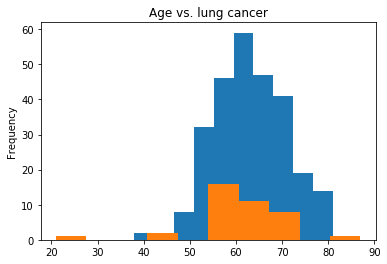

In [4]:
yes_data[AGE].plot(title="Age vs. lung cancer", kind="hist")
no_data[AGE].plot(kind="hist")

## Smoking

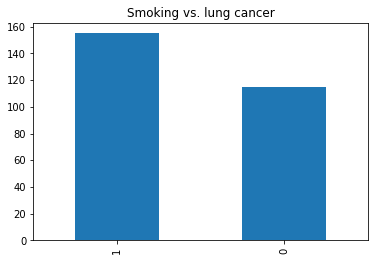

In [5]:
yes_data[SMOKING].value_counts().plot(title="Smoking vs. lung cancer", kind="bar")

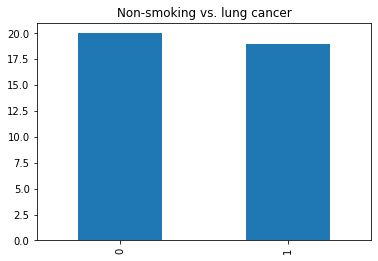

In [6]:
no_data[SMOKING].value_counts().plot(title="Non-smoking vs. lung cancer", kind="bar")

## Chronic Disease

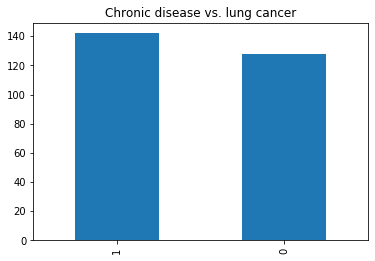

In [7]:
yes_data[CHRONIC_DISEASE].value_counts().plot(title="Chronic disease vs. lung cancer", kind="bar")

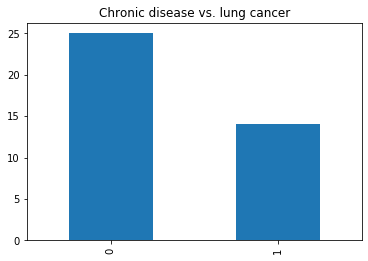

In [8]:
no_data[CHRONIC_DISEASE].value_counts().plot(title="Chronic disease vs. lung cancer", kind="bar")

# Part 2: Making Predictions

In [9]:
# Separate the data into training and validation sets
data_X = data.iloc[:, 0:15]
data_X = preprocessing.scale(data_X) # Scaling helps LinearSVC converge
data_y = data.iloc[:, 15]
train_X, test_X, train_y, test_y = model_selection.train_test_split(data_X, data_y, test_size=0.5, random_state=0)

In [30]:
def run_classifiers(classifiers, train_X, train_y, test_X, test_y):
    """
    Fits each classifier to the training data and runs it on the test data.
    Prints out the training and test accuracies. 
    """
    results = [] # list of 3-tuples: (classifier name, train accuracy, test accuracy)
    
    # Baseline: a random predictor that guesses "YES" for each data point
    rand_train_pred = np.full(train_y.size, 1)
    rand_test_pred = np.full(test_y.size, 1)
    
    rand_train_results = (rand_train_pred == train_y)    
    rand_train_acc = np.count_nonzero(rand_train_results) / train_y.size
    
    rand_test_results = (rand_test_pred == test_y)    
    rand_test_acc = np.count_nonzero(rand_test_results) / test_y.size
    
    # Print out precision/recall details for test class
    conf_mat = metrics.confusion_matrix(test_y, rand_test_pred)   
    
    print(f"Random classifier")
    
    # Precision rate = # true positives / (# predicted positives)
    # Recall rate = # true positives / # positive data points

    precision = conf_mat[1][1] / (conf_mat[1][1] + conf_mat[0][1])
    recall = conf_mat[1][1] / (conf_mat[1][1] + conf_mat[1][0])
    f1_score = 2 * ((precision * recall) / (precision + recall))

    print(f"Precision rate = {precision}")    
    print(f"Recall rate = {recall}")
    print(f"F1 score = {f1_score}\n")
    
    # Add random results to list
    results.append( ("Random Classifier", rand_train_acc, rand_test_acc))
    
    for clf in classifiers:       
        # Run classifier on train and test data
        clf.fit(train_X, train_y)
        train_pred = clf.predict(train_X)       
        train_acc = metrics.accuracy_score(train_y, train_pred)
        
        test_pred = clf.predict(test_X)
        test_acc = metrics.accuracy_score(test_y, test_pred)
        
        # Print out misclassification metrics
        conf_mat = metrics.confusion_matrix(test_y, test_pred)   
        precision = conf_mat[1][1] / (conf_mat[1][1] + conf_mat[0][1])
        recall = conf_mat[1][1] / (conf_mat[1][1] + conf_mat[1][0])
        f1_score = 2 * ((precision * recall) / (precision + recall))
        
        print(f"{type(clf).__name__}")
        print(f"Precision rate = {precision}")    
        print(f"Recall rate = {recall}")
        print(f"F1 score = {f1_score}\n")

        # Store results
        results.append( ((type(clf).__name__), train_acc, test_acc) )
        
    return results

In [31]:
classifiers = [
    neighbors.KNeighborsClassifier(),
    naive_bayes.GaussianNB(),
    discriminant_analysis.LinearDiscriminantAnalysis(),
    linear_model.LogisticRegression(solver="lbfgs", max_iter=200),
    tree.DecisionTreeClassifier(),
    ensemble.AdaBoostClassifier(),
    ensemble.RandomForestClassifier(n_estimators=100),
    svm.LinearSVC(C=0.01, max_iter=100)
]
results = run_classifiers(classifiers, train_X, train_y, test_X, test_y)
results

Random classifier
Precision rate = 0.8451612903225807
Recall rate = 1.0
F1 score = 0.9160839160839161

KNeighborsClassifier
Precision rate = 0.8928571428571429
Recall rate = 0.9541984732824428
F1 score = 0.922509225092251

GaussianNB
Precision rate = 0.917910447761194
Recall rate = 0.9389312977099237
F1 score = 0.9283018867924528

LinearDiscriminantAnalysis
Precision rate = 0.9338235294117647
Recall rate = 0.9694656488549618
F1 score = 0.951310861423221

LogisticRegression
Precision rate = 0.9084507042253521
Recall rate = 0.9847328244274809
F1 score = 0.945054945054945

DecisionTreeClassifier
Precision rate = 0.8880597014925373
Recall rate = 0.9083969465648855
F1 score = 0.8981132075471697

AdaBoostClassifier
Precision rate = 0.9191176470588235
Recall rate = 0.9541984732824428
F1 score = 0.9363295880149813

RandomForestClassifier
Precision rate = 0.8936170212765957
Recall rate = 0.9618320610687023
F1 score = 0.9264705882352942

LinearSVC
Precision rate = 0.8827586206896552
Recall rate 

[('Random Classifier', 0.9025974025974026, 0.8451612903225807),
 ('KNeighborsClassifier', 0.935064935064935, 0.864516129032258),
 ('GaussianNB', 0.9415584415584416, 0.8774193548387097),
 ('LinearDiscriminantAnalysis', 0.948051948051948, 0.9161290322580645),
 ('LogisticRegression', 0.948051948051948, 0.9032258064516129),
 ('DecisionTreeClassifier', 1.0, 0.8258064516129032),
 ('AdaBoostClassifier', 0.974025974025974, 0.8903225806451613),
 ('RandomForestClassifier', 1.0, 0.8709677419354839),
 ('LinearSVC', 0.935064935064935, 0.8709677419354839)]

## Training Results
The precision rates are all lower than the recall rates. This indicates that these models are more likely to predict positive, which is a consequence of having data skewed toward the positive class.

The Decision Tree and Random Forest Classifiers were able to classify the training data with 100% accuracy, but likely overfit the data.

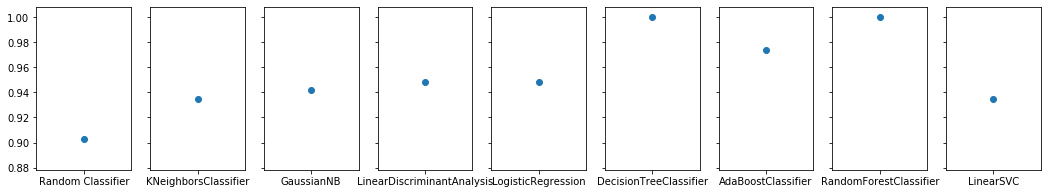

In [12]:
# Graph the results
classifier_names = [clf[0] for clf in results]
train_acc = [clf[1] for clf in results]
test_acc = [clf[2] for clf in results]

fig, ax = plt.subplots(1, len(classifier_names), figsize=(18, 3), sharey=True)
for i in range(len(classifier_names)):
    ax[i].scatter(classifier_names[i], train_acc[i])

## Test Results
Although the Decision Tree and Random Forest Classifiers had the highest training accuracies, the Linear Discriminant Analysis (LDA) classifier performed the best on the test data, with an accuracy of about 92%. It is likely that the Decision Tree and Random Forest classifiers overfit the training data.

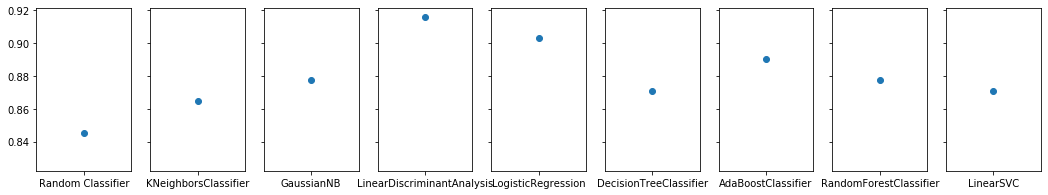

In [13]:
fig, ax = plt.subplots(1, len(classifier_names), figsize=(18, 3), sharey=True)
for i in range(len(classifier_names)):
    ax[i].scatter(classifier_names[i], test_acc[i])

# Conclusion

There are significantly more data points belonging to class lung cancer than data points not in the class. **As a result, it seems that the predictive models were biased toward characteristics of data points in the lung cancer class.** This might explain the larger number of false positives than false negatives.

Furthermore, it seems that the models do not generalize well to false negatives (i.e. when a person does not have lung cancer but the model predicts that they do). This could also be attributed to the disparity between the number data in the lung cancer class and those not in the class.

**The random classifier is able to obtain an 85% accuracy just by predicting "Yes" on each data point, whereas the best predictive models are only able to obtain a 91% accuracy.**

In [14]:
print(f"Number of data points belonging to class lung cancer = {yes_data.shape[0]}")
print(f"Number of data points *not* belonging to class lung cancer = {no_data.shape[0]}")
print(f"Percentage of data points belonging to class lung cancer = {yes_data.shape[0] / (data.shape[0])}")
print(f"Percentage of data points *not belonging to class lung cancer = {no_data.shape[0] / (data.shape[0])}")

Number of data points belonging to class lung cancer = 270
Number of data points *not* belonging to class lung cancer = 39
Percentage of data points belonging to class lung cancer = 0.8737864077669902
Percentage of data points *not belonging to class lung cancer = 0.1262135922330097
